<div style="background-image:url(images/header.svg); padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height: 250px">
    <div style="float:right; margin: 50px; padding: 20px; background:rgba(255,255,255,0.7); width: 50%; height: 150px">
        <div style="position:relative; top:50%; transform: translateY(-50%)">
            <div style="font-size: xx-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">Instaseis Tutorial</div>
            <div style="font-size: large; padding-top: 20px; color:rgba(0,0,0,0.5)">Part 1: Introduction</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Martin van Driel ([@martinvandriel](https://github.com/martinvandriel))
* Lion Krischer ([@krischer](https://github.com/krischer))
---

<img style="width:50%" src="images/logo.png">

**Goal:** calculate seismograms on a 1D background model with [Instaseis](http://www.instaseis.net), assuming the 
Green's function database computed with [AxiSEM](http://www.axisem.info) is provided.

### Overview:

**Introduction:**

* Part 1: Very basic introduction to the API, calculate the first seismogram.

**Basic Tasks:**

* Part 2: Some examples of interaction with obspy, calculate synthetics for a set of events and stations

**Advanced Tasks:**

* Part 3: Plot record section
* Part 4: Finite Source, compare to point source solution

-----

Basic lines to set up the notebook and some paths.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import obspy
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 8)

-----

## Basic Instaseis API Introduction

Please also have a look at our webpage - http://www.instaseis.net/ - where everything is documented extensively.

### Opening a Database

To get going you have to import the package `instaseis`.

In [2]:
import instaseis

An Instaseis database must be opened before it can be used. These can be either a local files computed with AxiSEM, or even more easily a remote database hosted by IRIS (http://ds.iris.edu/ds/products/syngine/).

In [3]:
db = instaseis.open_db("syngine://prem_a_10s")

Some basic information about the loaded database can be reviewed by just printing it.

In [4]:
print(db)

SyngineInstaseisDB reciprocal Green's function Database (v8) generated with these parameters:
Syngine model name:      'prem_a_10s'
Syngine service version:  1.0.1
	components           : vertical and horizontal
	velocity model       : prem_ani
	attenuation          : True
	dominant period      : 10.000 s
	dump type            : displ_only
	excitation type      : dipole
	time step            : 2.441 s
	sampling rate        : 0.410 Hz
	number of samples    : 7376
	seismogram length    : 17999.6 s
	source time function : gauss_0
	source shift         : 17.084 s
	spatial order        : 4
	min/max radius       : 5671.0 - 6371.0 km
	Planet radius        : 6371.0 km
	min/max distance     : 0.0 - 180.0 deg
	time stepping scheme : symplec4
	compiler/user        : gfortran 5.2.0 by productext on dpstage
	directory/url        : http://service.iris.edu/irisws/syngine/1
	size of netCDF files : 69.4 GB
	generated by AxiSEM version v1.2-31-g69d4-dirty at 2015-11-12T09:36:02.000000Z


From this you can already glance a couple of aspects of the database used for this tutorial:

* uses anisotropic prem as its 1D model
* is accurate for periods down to 10 seconds
* includes vertical and horizontal components
* sources can have depths ranging from 0 to 700 km
* five hour long seismograms

To avoid delays that become relevant when requesting very many seismograms, IRIS also offers the databases for download.

### Receivers and Sources

Instaseis calculates seismograms for any source and receiver pair. A receiver has coordinates and optionally network and station codes. Using a reciprocal database, all receivers are assumed to be at the same depth, i.e. usually at the Earth surface.

In [5]:
rec = instaseis.Receiver(latitude=44.06238, longitude=10.59698,
                         network="IV", station="BDI")
print(rec)

Instaseis Receiver:
	longitude :   10.6 deg
	latitude  :   44.1 deg
	network   : IV
	station   : BDI
	location  : 



Sources are naturally a bit more complex and Instaseis offers a variety of ways to define them. A straightforward way for earthquakes is to pass coordinates, moment as well as strike, dip and rake.

In [6]:
src = instaseis.Source.from_strike_dip_rake(
    latitude=27.77, longitude=85.37, depth_in_m=12000.0,
    M0=1e+21, strike=32., dip=62., rake=90.)
print(src)

Instaseis Source:
	origin time      : 1970-01-01T00:00:00.000000Z
	Longitude        :   85.4 deg
	Latitude         :   27.8 deg
	Depth            : 1.2e+01 km
	Moment Magnitude :   8.00
	Scalar Moment    :   1.00e+21 Nm
	Mrr              :   8.29e+20 Nm
	Mtt              :  -2.33e+20 Nm
	Mpp              :  -5.96e+20 Nm
	Mrt              :   2.96e+20 Nm
	Mrp              :   4.74e+20 Nm
	Mtp              :  -3.73e+20 Nm



Note that origin time was not provided and hence defaults to 1970.A non double-couple soure can directly be specified in terms of its moment tensor (note that instaseis uses SI units, i.e. NM, while GCMT uses dyn cm).

In [7]:
src = instaseis.Source(
    latitude=27.77, longitude=85.37, depth_in_m=12000.0,
    m_rr=8.29e+20, m_tt=-2.33e+20, m_pp=-5.96e+20,
    m_rt=2.96e+20, m_rp=4.74e+20, m_tp=-3.73e+20)
print(src)

Instaseis Source:
	origin time      : 1970-01-01T00:00:00.000000Z
	Longitude        :   85.4 deg
	Latitude         :   27.8 deg
	Depth            : 1.2e+01 km
	Moment Magnitude :   8.00
	Scalar Moment    :   1.00e+21 Nm
	Mrr              :   8.29e+20 Nm
	Mtt              :  -2.33e+20 Nm
	Mpp              :  -5.96e+20 Nm
	Mrt              :   2.96e+20 Nm
	Mrp              :   4.74e+20 Nm
	Mtp              :  -3.73e+20 Nm



**Sidenode:** The moment tensor can be visualized using the Beachball function from obspy.imaging:

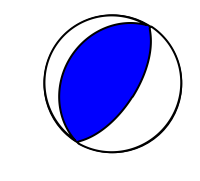

In [8]:
from obspy.imaging.beachball import beachball

mt = src.tensor / src.M0 # normalize the tensor to avoid problems in the plotting
beachball(mt, size=200, linewidth=2, facecolor='b');

Now we are ready to extract synthetic seismograms from the database. The return type is an [obspy stream object](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html), which can directly be plotted:

3 Trace(s) in Stream:
IV.BDI..LXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T04:59:42.561567Z | 0.4 Hz, 7369 samples
IV.BDI..LXN | 1970-01-01T00:00:00.000000Z - 1970-01-01T04:59:42.561567Z | 0.4 Hz, 7369 samples
IV.BDI..LXE | 1970-01-01T00:00:00.000000Z - 1970-01-01T04:59:42.561567Z | 0.4 Hz, 7369 samples


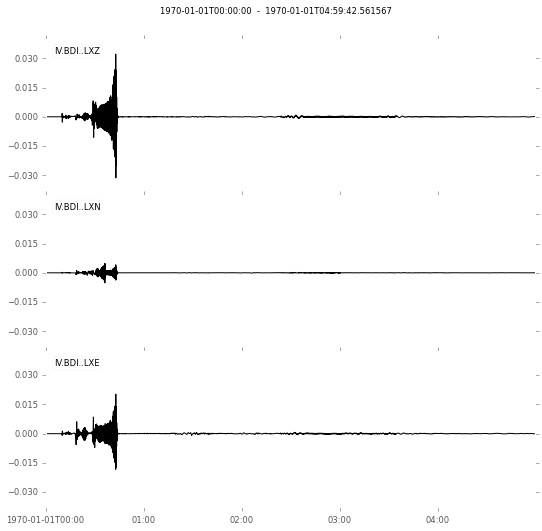

In [9]:
st = db.get_seismograms(source=src, receiver=rec)
print(st)
st.plot();

**Done** This is all you need for a basic usage of Instaseis!